Finding best time index for each region...

Africa:
  Best time index: 937 (2098-02-15T00:00:00.000000000)
    PLD-Res R²: 0.9336
    Advantage: 0.1128

Europe:
  Best time index: 744 (2082-01-16T12:00:00.000000000)
    PLD-Res R²: 0.8825
    Advantage: 0.5447

South Asia:
  Best time index: 869 (2092-06-16T00:00:00.000000000)
    PLD-Res R²: 0.9354
    Advantage: 0.1118

Australia:
  Best time index: 843 (2090-04-16T00:00:00.000000000)
    PLD-Res R²: 0.9455
    Advantage: 0.1745

North America:
  Best time index: 435 (2056-04-16T00:00:00.000000000)
    PLD-Res R²: 0.8503
    Advantage: 0.2799


/tmp/ipykernel_30447/3482158673.py:235: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0.03, 1, 1])


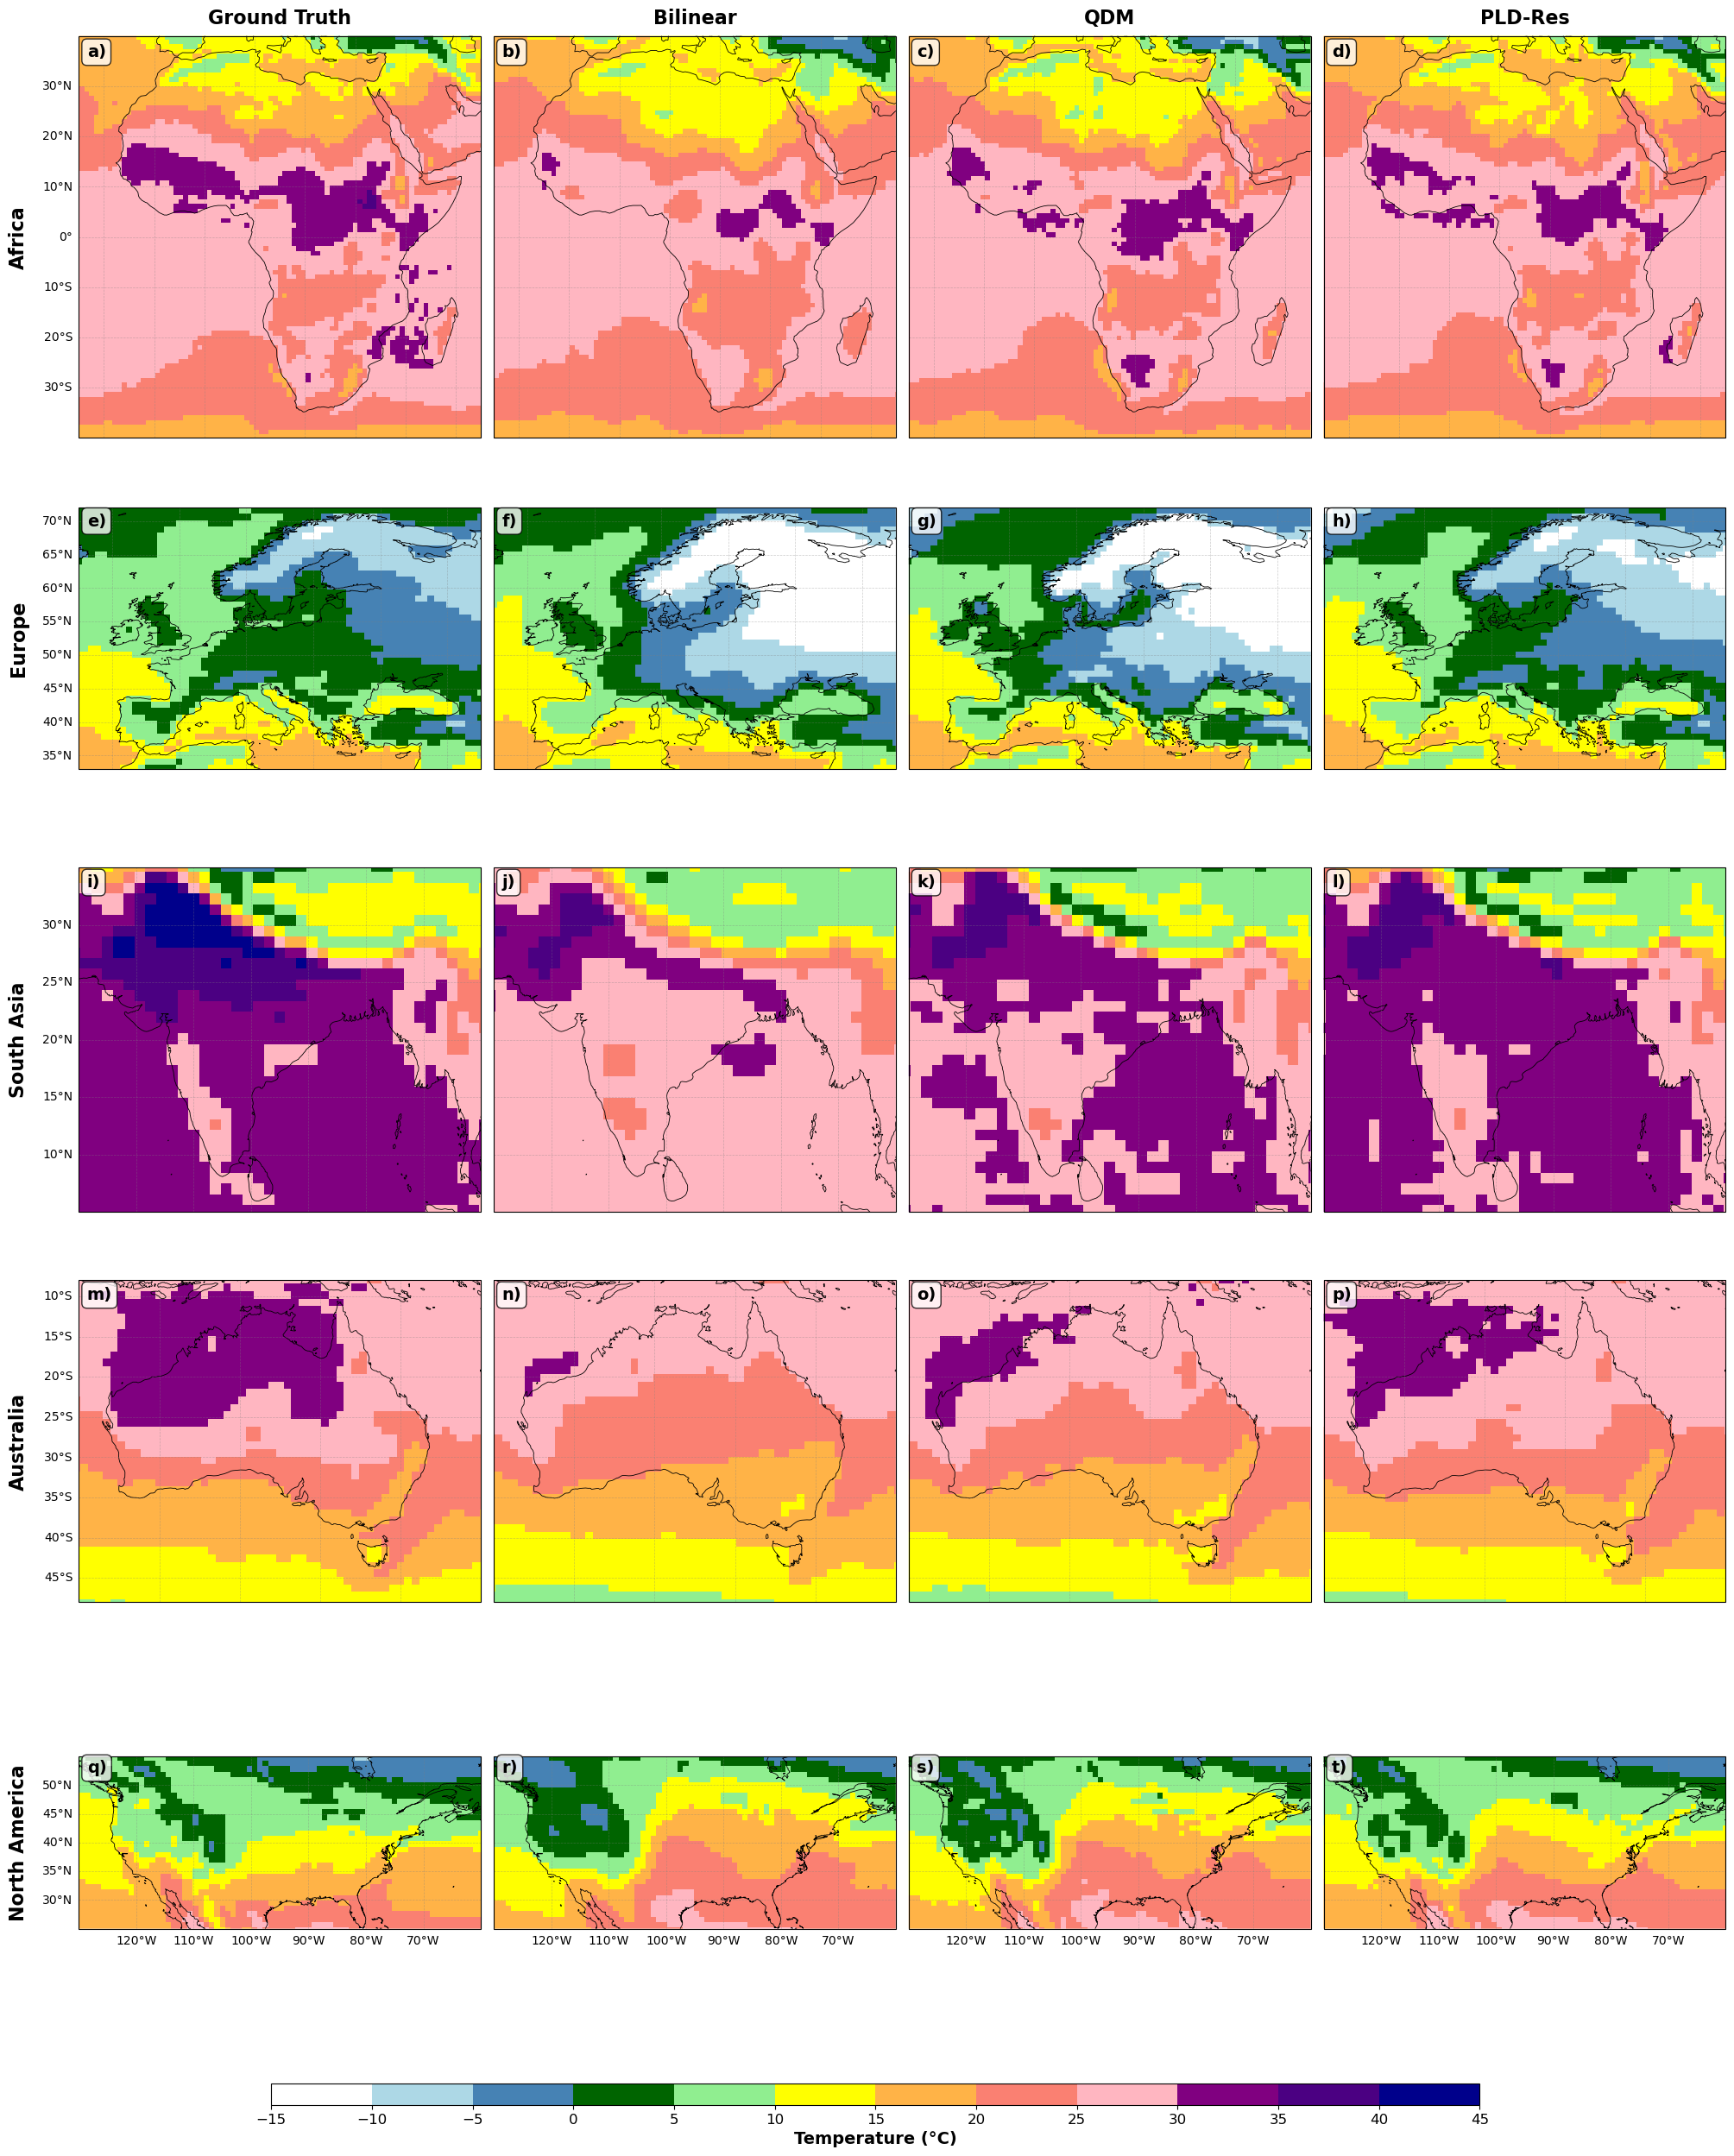

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

scenario = 'g6sulfur'

# Load data
ds_residual = xr.open_dataset(results_residual_dir / f"tas_evaluation_{scenario}.nc")
ds_main = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}.nc")
ds_qdm = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}_qdm.nc")

# Extract data
groundtruth = ds_residual['groundtruth'].values
bilinear = ds_residual['input'].values
zs_p = ds_main['pred_zscore_pixel'].values
raw_res = ds_residual['pred_raw'].values
pld_res = ds_residual['pred_grid'].values
qdm = ds_qdm['pred_qdm'].values

lat = ds_residual['lat'].values
lon = ds_residual['lon'].values
time = ds_residual['time']

# Define regions with correct lon coordinates (0-360)
regions = {
    'Africa': {
        'extent': [-25, 55, -40, 40],
        'lat_range': (-40, 40), 
        'lon_range': (335, 55)
    },
    'Europe': {
        'extent': [-15, 45, 33, 72],
        'lat_range': (33, 72), 
        'lon_range': (345, 45)
    },
    'South Asia': {
        'extent': [65, 100, 5, 35],
        'lat_range': (5, 35), 
        'lon_range': (65, 100)
    },
    'Australia': {
        'extent': [110, 160, -48, -8],
        'lat_range': (-48, -8), 
        'lon_range': (110, 160)
    },
    'North America': {
        'extent': [-130, -60, 25, 55],
        'lat_range': (25, 55),
        'lon_range': (230, 300)
    }
}

region_order = ['Africa', 'Europe', 'South Asia', 'Australia', 'North America']

def compute_regional_r2(pred, gt, lat, lon, lat_range, lon_range):
    """Calculate R² for a region, excluding NaN values"""
    lat_mask = (lat >= lat_range[0]) & (lat <= lat_range[1])
    
    if lon_range[0] > lon_range[1]:
        lon_mask = (lon >= lon_range[0]) | (lon <= lon_range[1])
    else:
        lon_mask = (lon >= lon_range[0]) & (lon <= lon_range[1])
    
    mask_2d = lat_mask[:, np.newaxis] & lon_mask[np.newaxis, :]
    
    n_time = pred.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_regional = pred[t][mask_2d]
        gt_regional = gt[t][mask_2d]
        
        valid_mask = ~(np.isnan(pred_regional) | np.isnan(gt_regional))
        pred_valid = pred_regional[valid_mask]
        gt_valid = gt_regional[valid_mask]
        
        if len(pred_valid) == 0:
            r2_values.append(np.nan)
            continue
        
        ss_res = np.sum((gt_valid - pred_valid)**2)
        ss_tot = np.sum((gt_valid - np.mean(gt_valid))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# Calculate best time index for each region
print("Finding best time index for each region...")
best_times = {}

methods = {
    'Bilinear': bilinear,
    'QDM': qdm,
}

for region_name in region_order:
    region_info = regions[region_name]
    print(f"\n{region_name}:")
    
    pld_r2 = compute_regional_r2(pld_res, groundtruth, lat, lon, 
                                  region_info['lat_range'], region_info['lon_range'])
    
    other_r2 = {}
    for method_name, method_data in methods.items():
        r2 = compute_regional_r2(method_data, groundtruth, lat, lon,
                                 region_info['lat_range'], region_info['lon_range'])
        other_r2[method_name] = r2
    
    valid_mask = ~np.isnan(pld_r2)
    for method_r2 in other_r2.values():
        valid_mask &= ~np.isnan(method_r2)
    
    if not np.any(valid_mask):
        print("  No valid data points")
        best_times[region_name] = 0
        continue
    
    other_r2_mean = np.mean([other_r2[m] for m in methods.keys()], axis=0)
    r2_advantage = pld_r2 - other_r2_mean
    r2_advantage[~valid_mask] = np.nan
    
    max_adv_idx = np.nanargmax(r2_advantage)
    max_adv_time = time[max_adv_idx].values
    
    print(f"  Best time index: {max_adv_idx} ({max_adv_time})")
    print(f"    PLD-Res R²: {pld_r2[max_adv_idx]:.4f}")
    print(f"    Advantage: {r2_advantage[max_adv_idx]:.4f}")
    
    best_times[region_name] = max_adv_idx

# Create custom discrete colormap
colors = [
    '#FFFFFF',  # White (-15 to -10)
    '#ADD8E6',  # Light Blue (-10 to -5)
    '#4682B4',  # Medium Blue (-5 to 0)
    '#006400',  # Dark Green (0 to 5)
    '#90EE90',  # Light Green (5 to 10)
    '#FFFF00',  # Yellow (10 to 15)
    '#FFB347',  # Light Orange (15 to 20)
    '#FA8072',  # Salmon (20 to 25)
    '#FFB6C1',  # Pink (25 to 30)
    '#800080',  # Purple (30 to 35)
    '#4B0082',  # Indigo (35 to 40)
    '#00008B',  # Dark Blue (40 to 45)
]

boundaries = [-15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, len(colors))

# Create 5x4 subplot figure with equal aspect ratio
fig = plt.figure(figsize=(20, 25))

lon_2d, lat_2d = np.meshgrid(lon, lat)

# Model order for columns
model_data = [groundtruth, bilinear, qdm, pld_res]
model_names = ['Ground Truth', 'Bilinear', 'QDM', 'PLD-Res']

# Panel labels
panel_labels = [chr(97 + i) + ')' for i in range(20)]

# Create subplots with PlateCarree projection
for row_idx, region_name in enumerate(region_order):
    region_info = regions[region_name]
    time_idx = best_times[region_name]
    
    for col_idx, (data, model_name) in enumerate(zip(model_data, model_names)):
        panel_idx = row_idx * 4 + col_idx
        ax = fig.add_subplot(5, 4, panel_idx + 1, projection=ccrs.PlateCarree())
        
        im = ax.pcolormesh(lon_2d, lat_2d, data[time_idx],
                          transform=ccrs.PlateCarree(),
                          cmap=cmap, norm=norm,
                          shading='auto')
        
        # Only coastlines, no borders or ocean fill
        ax.coastlines(linewidth=0.6, color='black')
        
        # Set regional extent
        ax.set_extent(region_info['extent'], crs=ccrs.PlateCarree())
        
        # Set aspect ratio to equal
        ax.set_aspect('equal')
        
        # Add gridlines
        gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                         alpha=0.4, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        
        # Only show left labels for first column
        if col_idx > 0:
            gl.left_labels = False
        
        # Only show bottom labels for last row
        if row_idx < 4:
            gl.bottom_labels = False
        
        # Add title only for first row
        if row_idx == 0:
            ax.set_title(model_name, fontsize=16, fontweight='bold', pad=10)
        
        # Add region label on first column
        if col_idx == 0:
            ax.text(-0.15, 0.5, region_name,
                   transform=ax.transAxes,
                   fontsize=16, fontweight='bold',
                   rotation=90, va='center', ha='center')
        
        # Add panel label
        ax.text(0.02, 0.98, panel_labels[panel_idx],
               transform=ax.transAxes,
               fontsize=14, fontweight='bold',
               verticalalignment='top',
               bbox=dict(boxstyle='round', facecolor='white', alpha=0.8, pad=0.3))

# Add colorbar
cbar_ax = fig.add_axes([0.15, 0.015, 0.7, 0.01])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='horizontal', 
                    spacing='uniform', ticks=boundaries)
cbar.set_label('Temperature (°C)', fontsize=14, fontweight='bold')
cbar.ax.tick_params(labelsize=12)

plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

Finding best time index for Africa...
Best time index: 937
Time: 2098-02-15T00:00:00.000000000
PLD-Res R²: 0.9336


/tmp/ipykernel_30447/1297864874.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


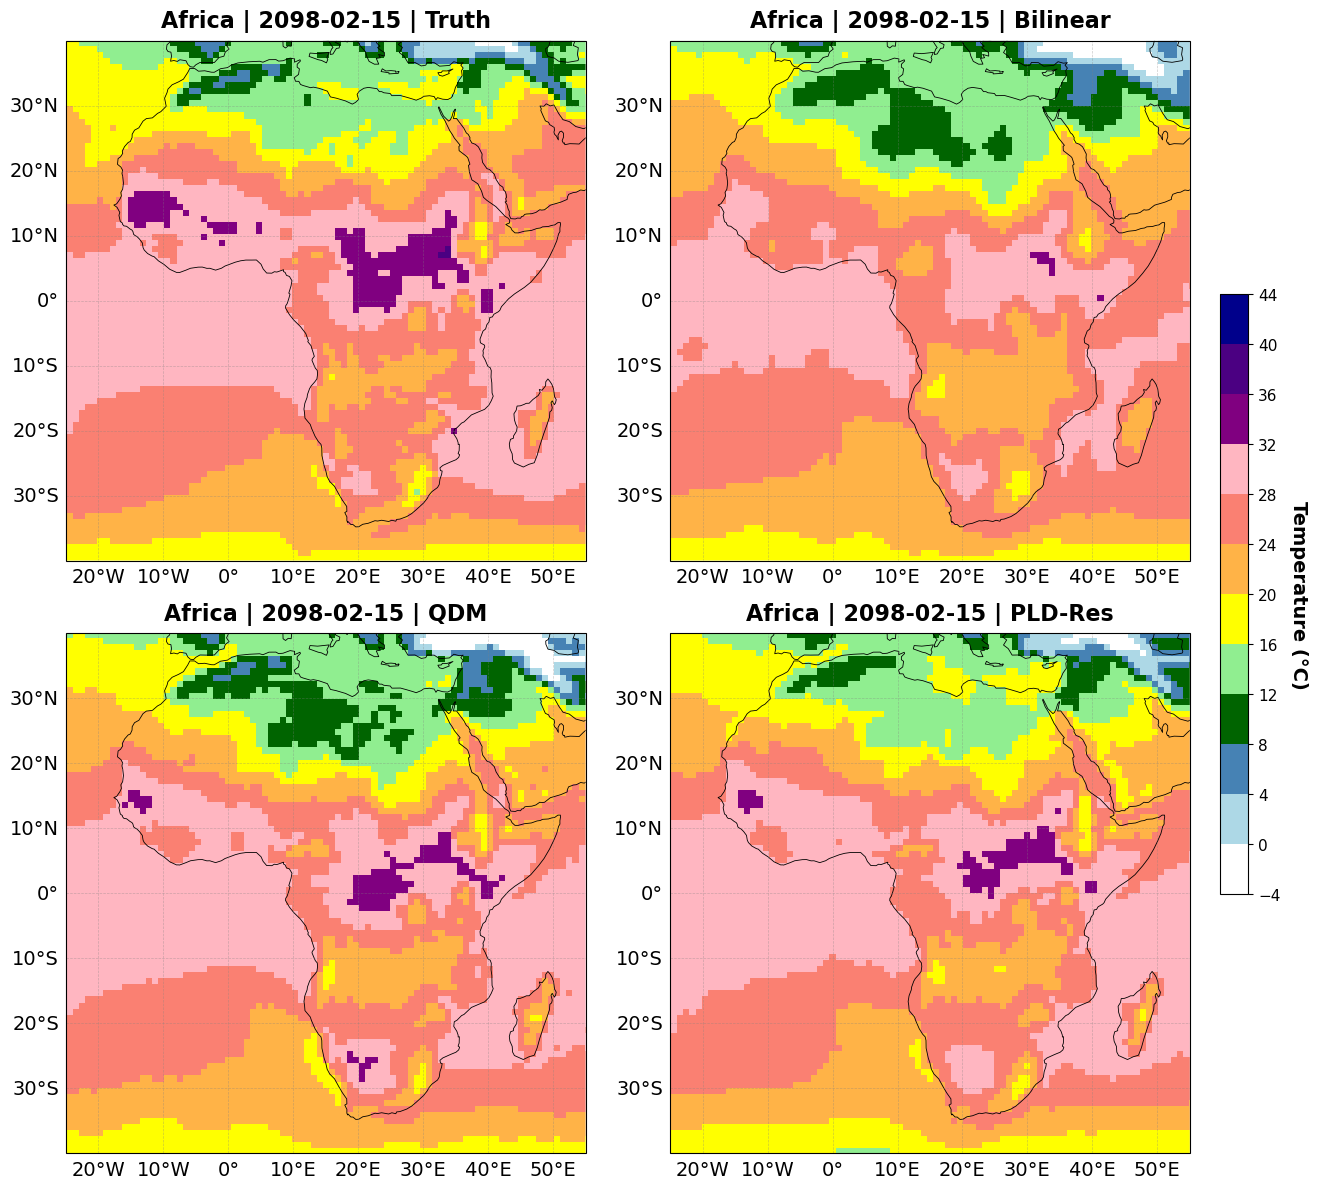

In [34]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

scenario = 'g6sulfur'

# Load data
ds_residual = xr.open_dataset(results_residual_dir / f"tas_evaluation_{scenario}.nc")
ds_main = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}.nc")
ds_qdm = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}_qdm.nc")

# Extract data
groundtruth = ds_residual['groundtruth'].values
bilinear = ds_residual['input'].values
pld_res = ds_residual['pred_grid'].values
qdm = ds_qdm['pred_qdm'].values

lat = ds_residual['lat'].values
lon = ds_residual['lon'].values
time = ds_residual['time']

# Define Africa region
africa_region = {
    'extent': [-25, 55, -40, 40],
    'lat_range': (-40, 40), 
    'lon_range': (335, 55)
}

def compute_regional_r2(pred, gt, lat, lon, lat_range, lon_range):
    """Calculate R² for a region, excluding NaN values"""
    lat_mask = (lat >= lat_range[0]) & (lat <= lat_range[1])
    
    if lon_range[0] > lon_range[1]:
        lon_mask = (lon >= lon_range[0]) | (lon <= lon_range[1])
    else:
        lon_mask = (lon >= lon_range[0]) & (lon <= lon_range[1])
    
    mask_2d = lat_mask[:, np.newaxis] & lon_mask[np.newaxis, :]
    
    n_time = pred.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_regional = pred[t][mask_2d]
        gt_regional = gt[t][mask_2d]
        
        valid_mask = ~(np.isnan(pred_regional) | np.isnan(gt_regional))
        pred_valid = pred_regional[valid_mask]
        gt_valid = gt_regional[valid_mask]
        
        if len(pred_valid) == 0:
            r2_values.append(np.nan)
            continue
        
        ss_res = np.sum((gt_valid - pred_valid)**2)
        ss_tot = np.sum((gt_valid - np.mean(gt_valid))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# Find best time index for Africa
print("Finding best time index for Africa...")

pld_r2 = compute_regional_r2(pld_res, groundtruth, lat, lon, 
                              africa_region['lat_range'], africa_region['lon_range'])

other_r2 = {}
other_r2['Bilinear'] = compute_regional_r2(bilinear, groundtruth, lat, lon,
                                          africa_region['lat_range'], africa_region['lon_range'])
other_r2['QDM'] = compute_regional_r2(qdm, groundtruth, lat, lon,
                                     africa_region['lat_range'], africa_region['lon_range'])

valid_mask = ~np.isnan(pld_r2)
for method_r2 in other_r2.values():
    valid_mask &= ~np.isnan(method_r2)

other_r2_mean = np.mean([other_r2[m] for m in other_r2.keys()], axis=0)
r2_advantage = pld_r2 - other_r2_mean
r2_advantage[~valid_mask] = np.nan

best_time_idx = np.nanargmax(r2_advantage)
best_time = time[best_time_idx].values

print(f"Best time index: {best_time_idx}")
print(f"Time: {best_time}")
print(f"PLD-Res R²: {pld_r2[best_time_idx]:.4f}")

# Format time as Year-Month-Day
time_str = pd.Timestamp(best_time).strftime('%Y-%m-%d')

# Create custom discrete colormap
colors = [
    '#FFFFFF',  # White (-4 to 0)
    '#ADD8E6',  # Light Blue (0 to 4)
    '#4682B4',  # Medium Blue (4 to 8)
    '#006400',  # Dark Green (8 to 12)
    '#90EE90',  # Light Green (12 to 16)
    '#FFFF00',  # Yellow (16 to 20)
    '#FFB347',  # Light Orange (20 to 24)
    '#FA8072',  # Salmon (24 to 28)
    '#FFB6C1',  # Pink (28 to 32)
    '#800080',  # Purple (32 to 36)
    '#4B0082',  # Indigo (36 to 40)
    '#00008B',  # Dark Blue (40 to 44)
]

boundaries = [-4, 0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, len(colors))

# Create 2x2 subplot figure
fig = plt.figure(figsize=(14, 12))

lon_2d, lat_2d = np.meshgrid(lon, lat)

# Model data and names
model_data = [groundtruth[best_time_idx], bilinear[best_time_idx], 
              qdm[best_time_idx], pld_res[best_time_idx]]
model_names = ['Truth', 'Bilinear', 'QDM', 'PLD-Res']

# Create subplots
for i, (data, model_name) in enumerate(zip(model_data, model_names)):
    ax = fig.add_subplot(2, 2, i + 1, projection=ccrs.PlateCarree())
    
    im = ax.pcolormesh(lon_2d, lat_2d, data,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm,
                      shading='auto')
    
    # Only coastlines
    ax.coastlines(linewidth=0.6, color='black')
    
    # Set regional extent
    ax.set_extent(africa_region['extent'], crs=ccrs.PlateCarree())
    
    # Set aspect ratio to equal
    ax.set_aspect('equal')
    
    # Add gridlines with labels on ALL panels
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                     alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    
    # Add title with date
    ax.set_title(f'Africa | {time_str} | {model_name}', fontsize=16, fontweight='bold', pad=10)

# Add colorbar on the right side
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', 
                    spacing='uniform', ticks=boundaries)
cbar.set_label('Temperature (°C)', fontsize=14, fontweight='bold', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout(rect=[0, 0, 0.9, 1])

# Save figure
output_file = figures_dir / "africa.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')


plt.show()

Finding best time index for Europe...
Best time index: 744
Time: 2082-01-16T12:00:00.000000000
PLD-Res R²: 0.8825


/tmp/ipykernel_30447/2951028310.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


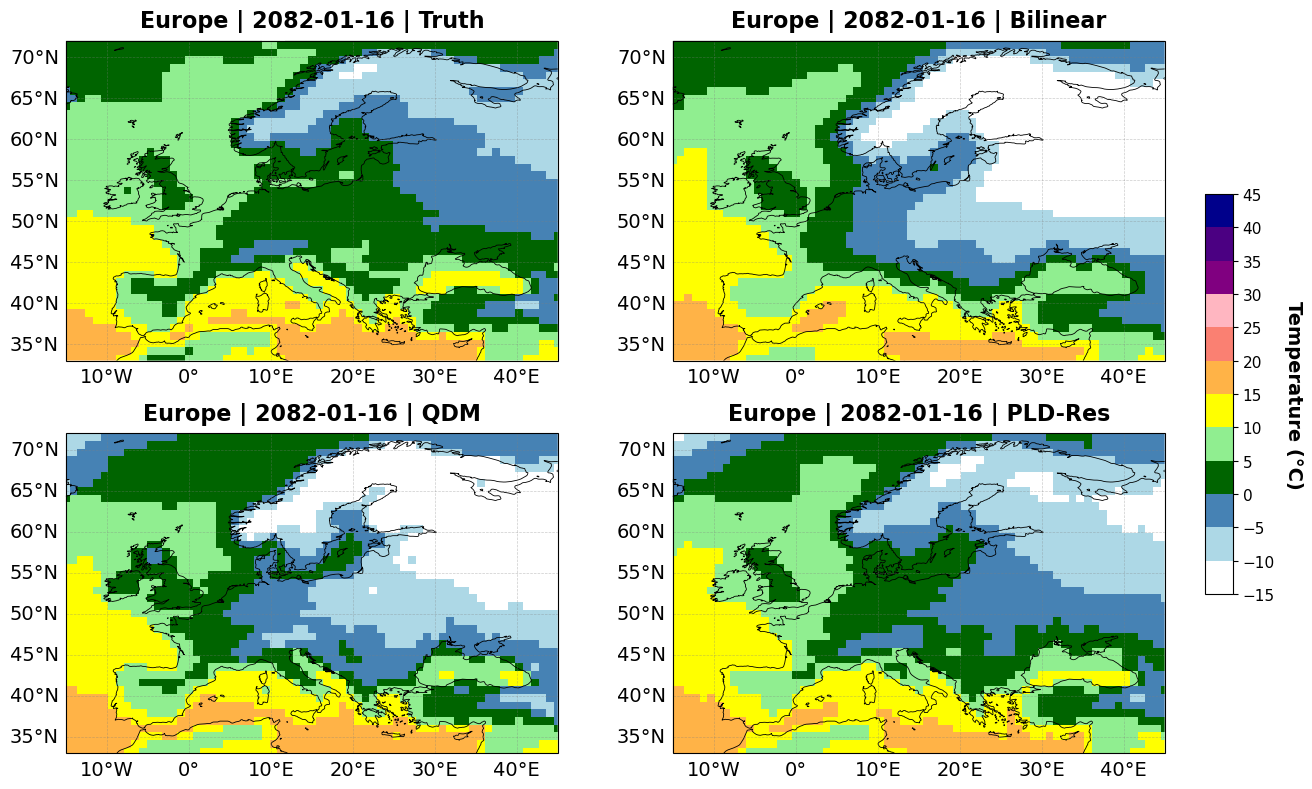

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

scenario = 'g6sulfur'

# Load data
ds_residual = xr.open_dataset(results_residual_dir / f"tas_evaluation_{scenario}.nc")
ds_main = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}.nc")
ds_qdm = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}_qdm.nc")

# Extract data
groundtruth = ds_residual['groundtruth'].values
bilinear = ds_residual['input'].values
pld_res = ds_residual['pred_grid'].values
qdm = ds_qdm['pred_qdm'].values

lat = ds_residual['lat'].values
lon = ds_residual['lon'].values
time = ds_residual['time']

# Define Europe region
europe_region = {
    'extent': [-15, 45, 33, 72],
    'lat_range': (33, 72), 
    'lon_range': (345, 45)
}

def compute_regional_r2(pred, gt, lat, lon, lat_range, lon_range):
    """Calculate R² for a region, excluding NaN values"""
    lat_mask = (lat >= lat_range[0]) & (lat <= lat_range[1])
    
    if lon_range[0] > lon_range[1]:
        lon_mask = (lon >= lon_range[0]) | (lon <= lon_range[1])
    else:
        lon_mask = (lon >= lon_range[0]) & (lon <= lon_range[1])
    
    mask_2d = lat_mask[:, np.newaxis] & lon_mask[np.newaxis, :]
    
    n_time = pred.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_regional = pred[t][mask_2d]
        gt_regional = gt[t][mask_2d]
        
        valid_mask = ~(np.isnan(pred_regional) | np.isnan(gt_regional))
        pred_valid = pred_regional[valid_mask]
        gt_valid = gt_regional[valid_mask]
        
        if len(pred_valid) == 0:
            r2_values.append(np.nan)
            continue
        
        ss_res = np.sum((gt_valid - pred_valid)**2)
        ss_tot = np.sum((gt_valid - np.mean(gt_valid))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# Find best time index for Europe
print("Finding best time index for Europe...")

pld_r2 = compute_regional_r2(pld_res, groundtruth, lat, lon, 
                              europe_region['lat_range'], europe_region['lon_range'])

other_r2 = {}
other_r2['Bilinear'] = compute_regional_r2(bilinear, groundtruth, lat, lon,
                                          europe_region['lat_range'], europe_region['lon_range'])
other_r2['QDM'] = compute_regional_r2(qdm, groundtruth, lat, lon,
                                     europe_region['lat_range'], europe_region['lon_range'])

valid_mask = ~np.isnan(pld_r2)
for method_r2 in other_r2.values():
    valid_mask &= ~np.isnan(method_r2)

other_r2_mean = np.mean([other_r2[m] for m in other_r2.keys()], axis=0)
r2_advantage = pld_r2 - other_r2_mean
r2_advantage[~valid_mask] = np.nan

best_time_idx = np.nanargmax(r2_advantage)
best_time = time[best_time_idx].values

print(f"Best time index: {best_time_idx}")
print(f"Time: {best_time}")
print(f"PLD-Res R²: {pld_r2[best_time_idx]:.4f}")

# Format time as Year-Month-Day
time_str = pd.Timestamp(best_time).strftime('%Y-%m-%d')

# Create custom discrete colormap
colors = [
    '#FFFFFF',  # White (-4 to 0)
    '#ADD8E6',  # Light Blue (0 to 4)
    '#4682B4',  # Medium Blue (4 to 8)
    '#006400',  # Dark Green (8 to 12)
    '#90EE90',  # Light Green (12 to 16)
    '#FFFF00',  # Yellow (16 to 20)
    '#FFB347',  # Light Orange (20 to 24)
    '#FA8072',  # Salmon (24 to 28)
    '#FFB6C1',  # Pink (28 to 32)
    '#800080',  # Purple (32 to 36)
    '#4B0082',  # Indigo (36 to 40)
    '#00008B',  # Dark Blue (40 to 44)
]

boundaries =  [-15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, len(colors))

# Create 2x2 subplot figure
fig = plt.figure(figsize=(14, 8))

lon_2d, lat_2d = np.meshgrid(lon, lat)

# Model data and names
model_data = [groundtruth[best_time_idx], bilinear[best_time_idx], 
              qdm[best_time_idx], pld_res[best_time_idx]]
model_names = ['Truth', 'Bilinear', 'QDM', 'PLD-Res']

# Create subplots
for i, (data, model_name) in enumerate(zip(model_data, model_names)):
    ax = fig.add_subplot(2, 2, i + 1, projection=ccrs.PlateCarree())
    
    im = ax.pcolormesh(lon_2d, lat_2d, data,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm,
                      shading='auto')
    
    # Only coastlines
    ax.coastlines(linewidth=0.6, color='black')
    
    # Set regional extent
    ax.set_extent(europe_region['extent'], crs=ccrs.PlateCarree())
    
    # Set aspect ratio to equal
    ax.set_aspect('equal')
    
    # Add gridlines with labels on ALL panels
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                     alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    
    # Add title with date
    ax.set_title(f'Europe | {time_str} | {model_name}', fontsize=16, fontweight='bold', pad=10)

# Add colorbar on the right side
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', 
                    spacing='uniform', ticks=boundaries)
cbar.set_label('Temperature (°C)', fontsize=14, fontweight='bold', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout(rect=[0, 0, 0.9, 1])

# Save figure
output_file = figures_dir / "europe.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')


plt.show()

Finding best time index for India...
Best time index: 869
Time: 2092-06-16T00:00:00.000000000
PLD-Res R²: 0.9517


/tmp/ipykernel_30447/2334763805.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


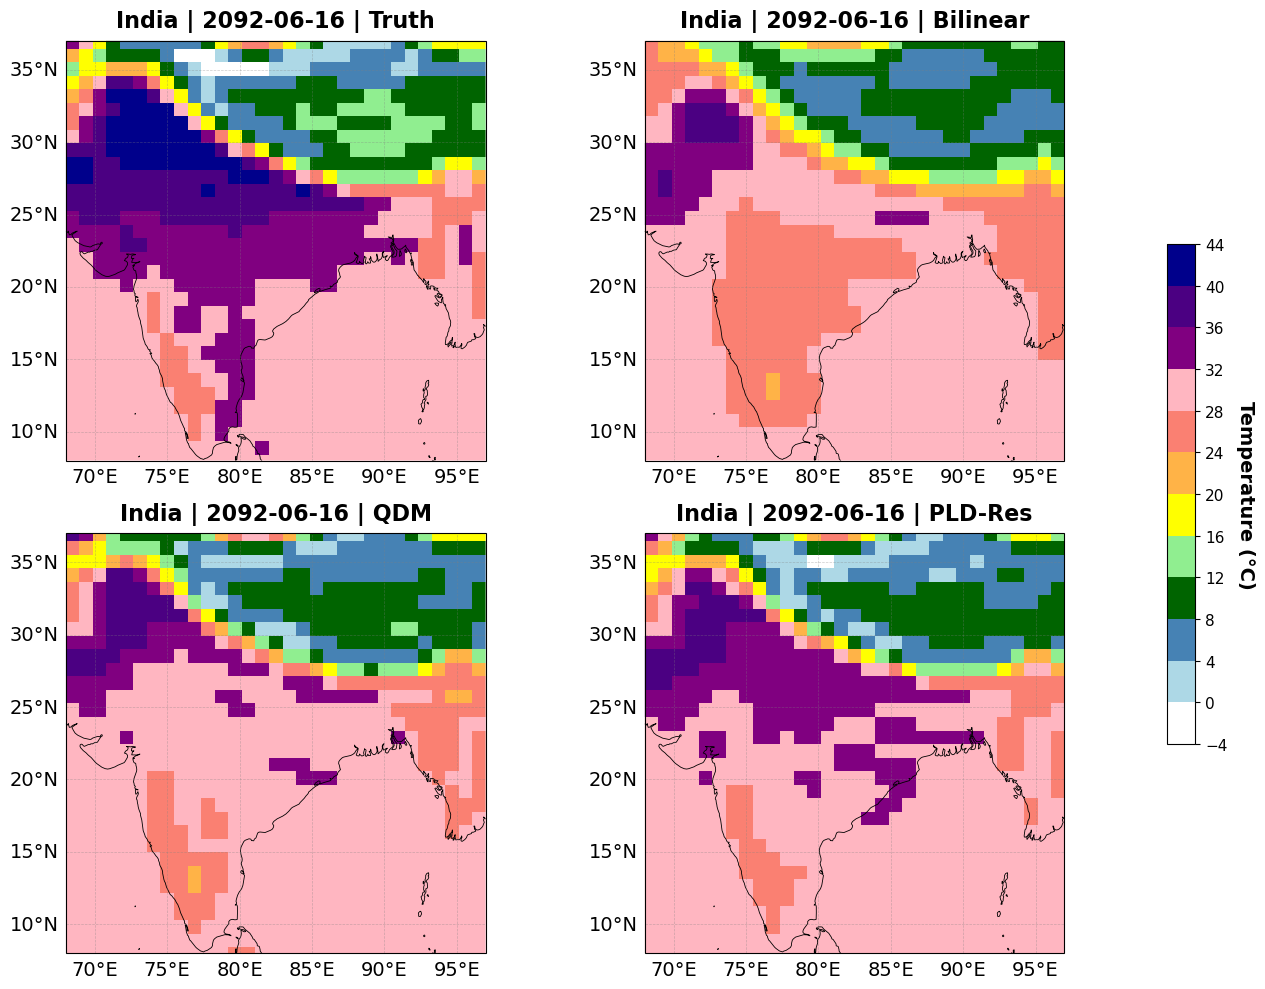

In [36]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

scenario = 'g6sulfur'

# Load data
ds_residual = xr.open_dataset(results_residual_dir / f"tas_evaluation_{scenario}.nc")
ds_main = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}.nc")
ds_qdm = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}_qdm.nc")

# Extract data
groundtruth = ds_residual['groundtruth'].values
bilinear = ds_residual['input'].values
pld_res = ds_residual['pred_grid'].values
qdm = ds_qdm['pred_qdm'].values

lat = ds_residual['lat'].values
lon = ds_residual['lon'].values
time = ds_residual['time']

# Define India region
india_region = {
    'extent': [68, 97, 8, 37],
    'lat_range': (8, 37), 
    'lon_range': (68, 97)
}

def compute_regional_r2(pred, gt, lat, lon, lat_range, lon_range):
    """Calculate R² for a region, excluding NaN values"""
    lat_mask = (lat >= lat_range[0]) & (lat <= lat_range[1])
    
    if lon_range[0] > lon_range[1]:
        lon_mask = (lon >= lon_range[0]) | (lon <= lon_range[1])
    else:
        lon_mask = (lon >= lon_range[0]) & (lon <= lon_range[1])
    
    mask_2d = lat_mask[:, np.newaxis] & lon_mask[np.newaxis, :]
    
    n_time = pred.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_regional = pred[t][mask_2d]
        gt_regional = gt[t][mask_2d]
        
        valid_mask = ~(np.isnan(pred_regional) | np.isnan(gt_regional))
        pred_valid = pred_regional[valid_mask]
        gt_valid = gt_regional[valid_mask]
        
        if len(pred_valid) == 0:
            r2_values.append(np.nan)
            continue
        
        ss_res = np.sum((gt_valid - pred_valid)**2)
        ss_tot = np.sum((gt_valid - np.mean(gt_valid))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# Find best time index for India
print("Finding best time index for India...")

pld_r2 = compute_regional_r2(pld_res, groundtruth, lat, lon, 
                              india_region['lat_range'], india_region['lon_range'])

other_r2 = {}
other_r2['Bilinear'] = compute_regional_r2(bilinear, groundtruth, lat, lon,
                                          india_region['lat_range'], india_region['lon_range'])
other_r2['QDM'] = compute_regional_r2(qdm, groundtruth, lat, lon,
                                     india_region['lat_range'], india_region['lon_range'])

valid_mask = ~np.isnan(pld_r2)
for method_r2 in other_r2.values():
    valid_mask &= ~np.isnan(method_r2)

other_r2_mean = np.mean([other_r2[m] for m in other_r2.keys()], axis=0)
r2_advantage = pld_r2 - other_r2_mean
r2_advantage[~valid_mask] = np.nan

best_time_idx = np.nanargmax(r2_advantage)
best_time = time[best_time_idx].values

print(f"Best time index: {best_time_idx}")
print(f"Time: {best_time}")
print(f"PLD-Res R²: {pld_r2[best_time_idx]:.4f}")

# Format time as Year-Month-Day
time_str = pd.Timestamp(best_time).strftime('%Y-%m-%d')

# Create custom discrete colormap
colors = [
    '#FFFFFF',  # White (-4 to 0)
    '#ADD8E6',  # Light Blue (0 to 4)
    '#4682B4',  # Medium Blue (4 to 8)
    '#006400',  # Dark Green (8 to 12)
    '#90EE90',  # Light Green (12 to 16)
    '#FFFF00',  # Yellow (16 to 20)
    '#FFB347',  # Light Orange (20 to 24)
    '#FA8072',  # Salmon (24 to 28)
    '#FFB6C1',  # Pink (28 to 32)
    '#800080',  # Purple (32 to 36)
    '#4B0082',  # Indigo (36 to 40)
    '#00008B',  # Dark Blue (40 to 44)
]

boundaries = [-4, 0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, len(colors))

# Create 2x2 subplot figure
fig = plt.figure(figsize=(14, 10))

lon_2d, lat_2d = np.meshgrid(lon, lat)

# Model data and names
model_data = [groundtruth[best_time_idx], bilinear[best_time_idx], 
              qdm[best_time_idx], pld_res[best_time_idx]]
model_names = ['Truth', 'Bilinear', 'QDM', 'PLD-Res']

# Create subplots
for i, (data, model_name) in enumerate(zip(model_data, model_names)):
    ax = fig.add_subplot(2, 2, i + 1, projection=ccrs.PlateCarree())
    
    im = ax.pcolormesh(lon_2d, lat_2d, data,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm,
                      shading='auto')
    
    # Only coastlines
    ax.coastlines(linewidth=0.6, color='black')
    
    # Set regional extent
    ax.set_extent(india_region['extent'], crs=ccrs.PlateCarree())
    
    # Set aspect ratio to equal
    ax.set_aspect('equal')
    
    # Add gridlines with labels on ALL panels
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                     alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    
    # Add title with date
    ax.set_title(f'India | {time_str} | {model_name}', fontsize=16, fontweight='bold', pad=10)

# Add colorbar on the right side
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', 
                    spacing='uniform', ticks=boundaries)
cbar.set_label('Temperature (°C)', fontsize=14, fontweight='bold', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout(rect=[0, 0, 0.9, 1])

# Save figure
output_file = figures_dir / "india.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')


plt.show()

Finding best time index for USA...
Best time index: 895
Time: 2094-08-16T12:00:00.000000000
PLD-Res R²: 0.7382


/tmp/ipykernel_30447/2059643778.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


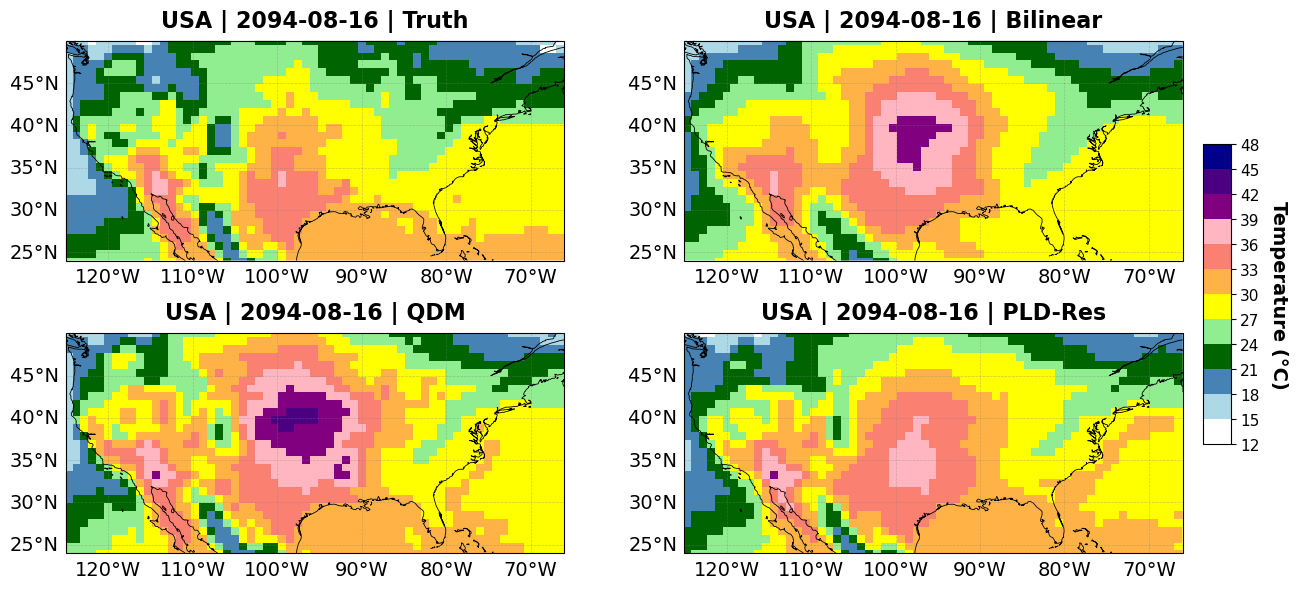

In [37]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

scenario = 'g6sulfur'

# Load data
ds_residual = xr.open_dataset(results_residual_dir / f"tas_evaluation_{scenario}.nc")
ds_main = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}.nc")
ds_qdm = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}_qdm.nc")

# Extract data
groundtruth = ds_residual['groundtruth'].values
bilinear = ds_residual['input'].values
pld_res = ds_residual['pred_grid'].values
qdm = ds_qdm['pred_qdm'].values

lat = ds_residual['lat'].values
lon = ds_residual['lon'].values
time = ds_residual['time']

# Define USA (contiguous United States) region
usa_region = {
    'extent': [-125, -66, 24, 50],  # Contiguous USA mainland
    'lat_range': (20, 50), 
    'lon_range': (235, 294)  # -125 to -66 in 0-360 coordinates
}

def compute_regional_r2(pred, gt, lat, lon, lat_range, lon_range):
    """Calculate R² for a region, excluding NaN values"""
    lat_mask = (lat >= lat_range[0]) & (lat <= lat_range[1])
    
    if lon_range[0] > lon_range[1]:
        lon_mask = (lon >= lon_range[0]) | (lon <= lon_range[1])
    else:
        lon_mask = (lon >= lon_range[0]) & (lon <= lon_range[1])
    
    mask_2d = lat_mask[:, np.newaxis] & lon_mask[np.newaxis, :]
    
    n_time = pred.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_regional = pred[t][mask_2d]
        gt_regional = gt[t][mask_2d]
        
        valid_mask = ~(np.isnan(pred_regional) | np.isnan(gt_regional))
        pred_valid = pred_regional[valid_mask]
        gt_valid = gt_regional[valid_mask]
        
        if len(pred_valid) == 0:
            r2_values.append(np.nan)
            continue
        
        ss_res = np.sum((gt_valid - pred_valid)**2)
        ss_tot = np.sum((gt_valid - np.mean(gt_valid))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# Find best time index for USA
print("Finding best time index for USA...")

pld_r2 = compute_regional_r2(pld_res, groundtruth, lat, lon, 
                              usa_region['lat_range'], usa_region['lon_range'])

other_r2 = {}
other_r2['Bilinear'] = compute_regional_r2(bilinear, groundtruth, lat, lon,
                                          usa_region['lat_range'], usa_region['lon_range'])
other_r2['QDM'] = compute_regional_r2(qdm, groundtruth, lat, lon,
                                     usa_region['lat_range'], usa_region['lon_range'])

valid_mask = ~np.isnan(pld_r2)
for method_r2 in other_r2.values():
    valid_mask &= ~np.isnan(method_r2)

other_r2_mean = np.mean([other_r2[m] for m in other_r2.keys()], axis=0)
r2_advantage = pld_r2 - other_r2_mean
r2_advantage[~valid_mask] = np.nan

best_time_idx = np.nanargmax(r2_advantage)
best_time = time[best_time_idx].values

print(f"Best time index: {best_time_idx}")
print(f"Time: {best_time}")
print(f"PLD-Res R²: {pld_r2[best_time_idx]:.4f}")

# Format time as Year-Month-Day
time_str = pd.Timestamp(best_time).strftime('%Y-%m-%d')

# Create custom discrete colormap
colors = [
    '#FFFFFF',  # White (-4 to 0)
    '#ADD8E6',  # Light Blue (0 to 4)
    '#4682B4',  # Medium Blue (4 to 8)
    '#006400',  # Dark Green (8 to 12)
    '#90EE90',  # Light Green (12 to 16)
    '#FFFF00',  # Yellow (16 to 20)
    '#FFB347',  # Light Orange (20 to 24)
    '#FA8072',  # Salmon (24 to 28)
    '#FFB6C1',  # Pink (28 to 32)
    '#800080',  # Purple (32 to 36)
    '#4B0082',  # Indigo (36 to 40)
    '#00008B',  # Dark Blue (40 to 44)
]

boundaries = [12, 15, 18, 21, 24, 27, 30, 33, 36, 39, 42, 45, 48]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, len(colors))

# Create 2x2 subplot figure
fig = plt.figure(figsize=(14, 6))

lon_2d, lat_2d = np.meshgrid(lon, lat)

# Model data and names
model_data = [groundtruth[best_time_idx], bilinear[best_time_idx], 
              qdm[best_time_idx], pld_res[best_time_idx]]
model_names = ['Truth', 'Bilinear', 'QDM', 'PLD-Res']

# Create subplots
for i, (data, model_name) in enumerate(zip(model_data, model_names)):
    ax = fig.add_subplot(2, 2, i + 1, projection=ccrs.PlateCarree())
    
    im = ax.pcolormesh(lon_2d, lat_2d, data,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm,
                      shading='auto')
    
    # Only coastlines
    ax.coastlines(linewidth=0.6, color='black')
    
    # Set regional extent
    ax.set_extent(usa_region['extent'], crs=ccrs.PlateCarree())
    
    # Set aspect ratio to equal
    ax.set_aspect('equal')
    
    # Add gridlines with labels on ALL panels
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                     alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    
    # Add title with date
    ax.set_title(f'USA | {time_str} | {model_name}', fontsize=16, fontweight='bold', pad=10)

# Add colorbar on the right side
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', 
                    spacing='uniform', ticks=boundaries)
cbar.set_label('Temperature (°C)', fontsize=14, fontweight='bold', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout(rect=[0, 0, 0.9, 1])

# Save figure
output_file = figures_dir / "usa.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

plt.show()

Finding best time index for Australia...
Best time index: 843
Time: 2090-04-16T00:00:00.000000000
PLD-Res R²: 0.9455


/tmp/ipykernel_30447/3901422136.py:170: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


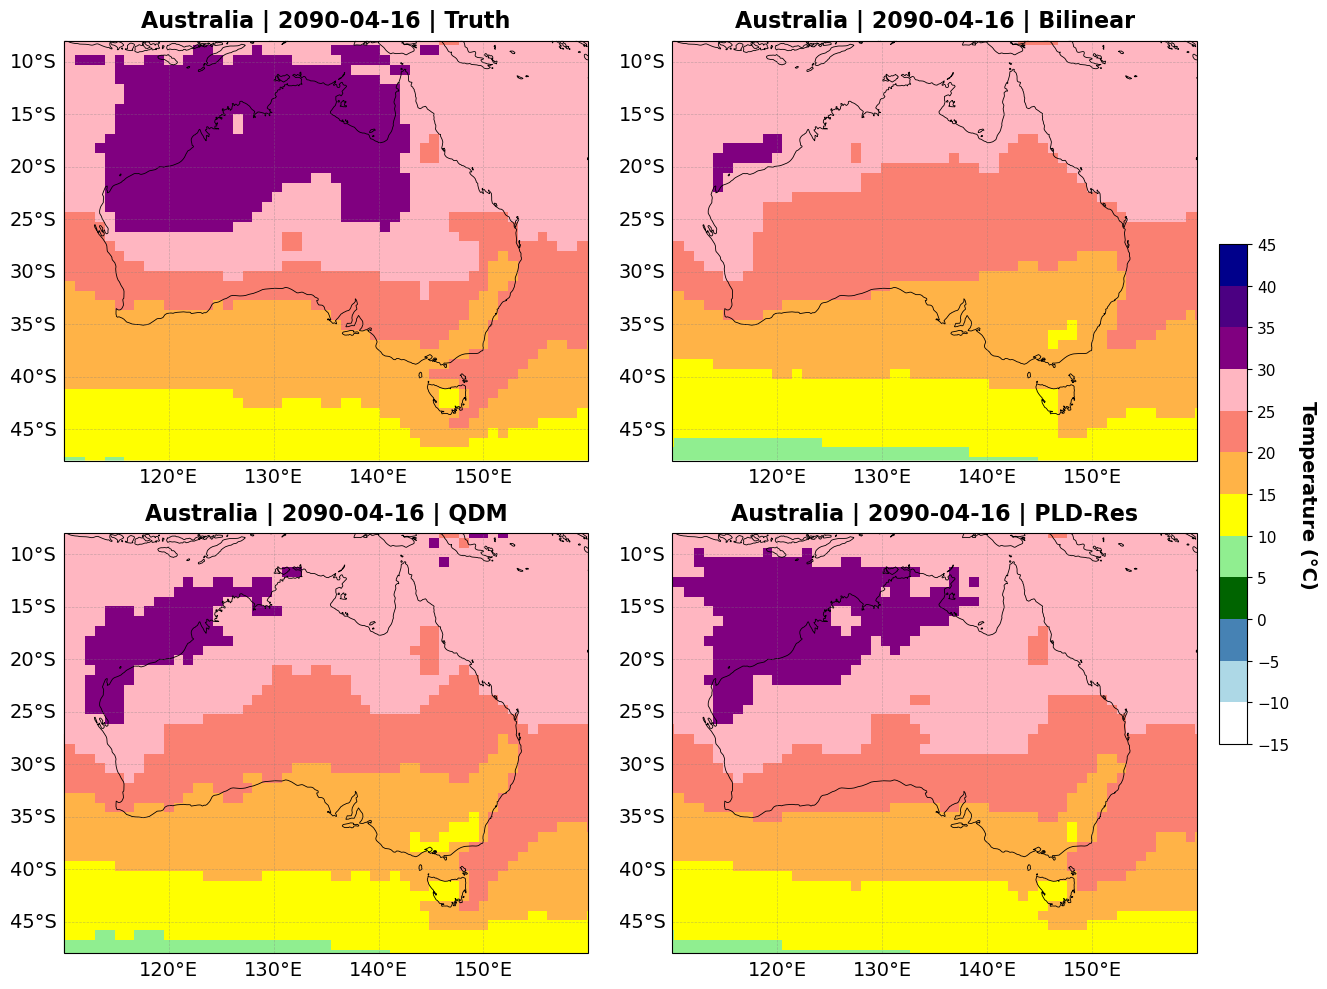

In [39]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from pathlib import Path
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.colors import ListedColormap, BoundaryNorm
import pandas as pd

# Configuration
results_dir = Path("../evaluation_results")
results_residual_dir = Path("../evaluation_results_residual")
figures_dir = Path("../Figures")

scenario = 'g6sulfur'

# Load data
ds_residual = xr.open_dataset(results_residual_dir / f"tas_evaluation_{scenario}.nc")
ds_main = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}.nc")
ds_qdm = xr.open_dataset(results_dir / f"tas_evaluation_{scenario}_qdm.nc")

# Extract data
groundtruth = ds_residual['groundtruth'].values
bilinear = ds_residual['input'].values
pld_res = ds_residual['pred_grid'].values
qdm = ds_qdm['pred_qdm'].values

lat = ds_residual['lat'].values
lon = ds_residual['lon'].values
time = ds_residual['time']

# Define Australia region
australia_region = {
    'extent': [110, 160, -48, -8],
    'lat_range': (-48, -8), 
    'lon_range': (110, 160)
}

def compute_regional_r2(pred, gt, lat, lon, lat_range, lon_range):
    """Calculate R² for a region, excluding NaN values"""
    lat_mask = (lat >= lat_range[0]) & (lat <= lat_range[1])
    
    if lon_range[0] > lon_range[1]:
        lon_mask = (lon >= lon_range[0]) | (lon <= lon_range[1])
    else:
        lon_mask = (lon >= lon_range[0]) & (lon <= lon_range[1])
    
    mask_2d = lat_mask[:, np.newaxis] & lon_mask[np.newaxis, :]
    
    n_time = pred.shape[0]
    r2_values = []
    
    for t in range(n_time):
        pred_regional = pred[t][mask_2d]
        gt_regional = gt[t][mask_2d]
        
        valid_mask = ~(np.isnan(pred_regional) | np.isnan(gt_regional))
        pred_valid = pred_regional[valid_mask]
        gt_valid = gt_regional[valid_mask]
        
        if len(pred_valid) == 0:
            r2_values.append(np.nan)
            continue
        
        ss_res = np.sum((gt_valid - pred_valid)**2)
        ss_tot = np.sum((gt_valid - np.mean(gt_valid))**2)
        r2 = 1 - (ss_res / ss_tot) if ss_tot > 0 else 0
        r2_values.append(r2)
    
    return np.array(r2_values)

# Find best time index for Australia
print("Finding best time index for Australia...")

pld_r2 = compute_regional_r2(pld_res, groundtruth, lat, lon, 
                              australia_region['lat_range'], australia_region['lon_range'])

other_r2 = {}
other_r2['Bilinear'] = compute_regional_r2(bilinear, groundtruth, lat, lon,
                                          australia_region['lat_range'], australia_region['lon_range'])
other_r2['QDM'] = compute_regional_r2(qdm, groundtruth, lat, lon,
                                     australia_region['lat_range'], australia_region['lon_range'])

valid_mask = ~np.isnan(pld_r2)
for method_r2 in other_r2.values():
    valid_mask &= ~np.isnan(method_r2)

other_r2_mean = np.mean([other_r2[m] for m in other_r2.keys()], axis=0)
r2_advantage = pld_r2 - other_r2_mean
r2_advantage[~valid_mask] = np.nan

best_time_idx = np.nanargmax(r2_advantage)
best_time = time[best_time_idx].values

print(f"Best time index: {best_time_idx}")
print(f"Time: {best_time}")
print(f"PLD-Res R²: {pld_r2[best_time_idx]:.4f}")

# Format time as Year-Month-Day
time_str = pd.Timestamp(best_time).strftime('%Y-%m-%d')

# Create custom discrete colormap
colors = [
    '#FFFFFF',  # White (-4 to 0)
    '#ADD8E6',  # Light Blue (0 to 4)
    '#4682B4',  # Medium Blue (4 to 8)
    '#006400',  # Dark Green (8 to 12)
    '#90EE90',  # Light Green (12 to 16)
    '#FFFF00',  # Yellow (16 to 20)
    '#FFB347',  # Light Orange (20 to 24)
    '#FA8072',  # Salmon (24 to 28)
    '#FFB6C1',  # Pink (28 to 32)
    '#800080',  # Purple (32 to 36)
    '#4B0082',  # Indigo (36 to 40)
    '#00008B',  # Dark Blue (40 to 44)
]

boundaries = [-15, -10, -5, 0, 5, 10, 15, 20, 25, 30, 35, 40, 45]
cmap = ListedColormap(colors)
norm = BoundaryNorm(boundaries, len(colors))

# Create 2x2 subplot figure
fig = plt.figure(figsize=(14, 10))

lon_2d, lat_2d = np.meshgrid(lon, lat)

# Model data and names
model_data = [groundtruth[best_time_idx], bilinear[best_time_idx], 
              qdm[best_time_idx], pld_res[best_time_idx]]
model_names = ['Truth', 'Bilinear', 'QDM', 'PLD-Res']

# Create subplots
for i, (data, model_name) in enumerate(zip(model_data, model_names)):
    ax = fig.add_subplot(2, 2, i + 1, projection=ccrs.PlateCarree())
    
    im = ax.pcolormesh(lon_2d, lat_2d, data,
                      transform=ccrs.PlateCarree(),
                      cmap=cmap, norm=norm,
                      shading='auto')
    
    # Only coastlines
    ax.coastlines(linewidth=0.6, color='black')
    
    # Set regional extent
    ax.set_extent(australia_region['extent'], crs=ccrs.PlateCarree())
    
    # Set aspect ratio to equal
    ax.set_aspect('equal')
    
    # Add gridlines with labels on ALL panels
    gl = ax.gridlines(draw_labels=True, linewidth=0.5, color='gray', 
                     alpha=0.4, linestyle='--')
    gl.top_labels = False
    gl.right_labels = False
    gl.left_labels = True
    gl.bottom_labels = True
    gl.xlabel_style = {'size': 14, 'color': 'black'}
    gl.ylabel_style = {'size': 14, 'color': 'black'}
    
    # Add title with date
    ax.set_title(f'Australia | {time_str} | {model_name}', fontsize=16, fontweight='bold', pad=10)

# Add colorbar on the right side
cbar_ax = fig.add_axes([0.88, 0.25, 0.02, 0.5])
cbar = fig.colorbar(im, cax=cbar_ax, orientation='vertical', 
                    spacing='uniform', ticks=boundaries)
cbar.set_label('Temperature (°C)', fontsize=14, fontweight='bold', rotation=270, labelpad=20)
cbar.ax.tick_params(labelsize=11)

plt.tight_layout(rect=[0, 0, 0.9, 1])

# Save figure
output_file = figures_dir / "australia.png"
plt.savefig(output_file, dpi=300, bbox_inches='tight')

plt.show()